In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

file_path = "Final Data.xlsx"
data = pd.read_excel(file_path)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Define columns
columns_to_normalize = [
    "Neighborhood Median After-Tax Income",
    "Neighborhood Adolescent Count",
    "Facilities per Population",
    "TTC Density(Routes per km^2)"
]

# Normalize the data
normalized_data = pd.DataFrame(scaler.fit_transform(data[columns_to_normalize]), columns=columns_to_normalize)

# Adjust scores based on priorities
normalized_data["Neighborhood Median After-Tax Income"] = 1 - normalized_data["Neighborhood Median After-Tax Income"]  # Lower is better
normalized_data["Facilities per Population"] = 1 - normalized_data["Facilities per Population"]  # Lower is better
# Higher is better for Adolescent Count and TTC Density, so leave them as is.

# Assign weights
# Weights are freely adjustable depending on the prevalence of each factor in each community/situation
weights = {
    "Neighborhood Median After-Tax Income": 0.3,
    "Neighborhood Adolescent Count": 0.4,
    "Facilities per Population": 0.2,
    "TTC Density(Routes per km^2)": 0.1
}

# Ensure weights sum to 1
assert abs(sum(weights.values()) - 1) < 1e-6, "Weights must sum to 1."

# Calculate the weighted score for each neighborhood
data["Score"] = (
    normalized_data["Neighborhood Median After-Tax Income"] * weights["Neighborhood Median After-Tax Income"] +
    normalized_data["Neighborhood Adolescent Count"] * weights["Neighborhood Adolescent Count"] +
    normalized_data["Facilities per Population"] * weights["Facilities per Population"] +
    normalized_data["TTC Density(Routes per km^2)"] * weights["TTC Density(Routes per km^2)"]
)

# Sort neighborhoods by score (higher score = higher priority)
data = data.sort_values(by="Score", ascending=False)

# Save the results to a new Excel file
data.to_excel("neighborhood_scores.xlsx", index=False)

print("Scores have been calculated and saved to 'neighborhood_scores.xlsx'")


Scores have been calculated and saved to 'neighborhood_scores.xlsx'


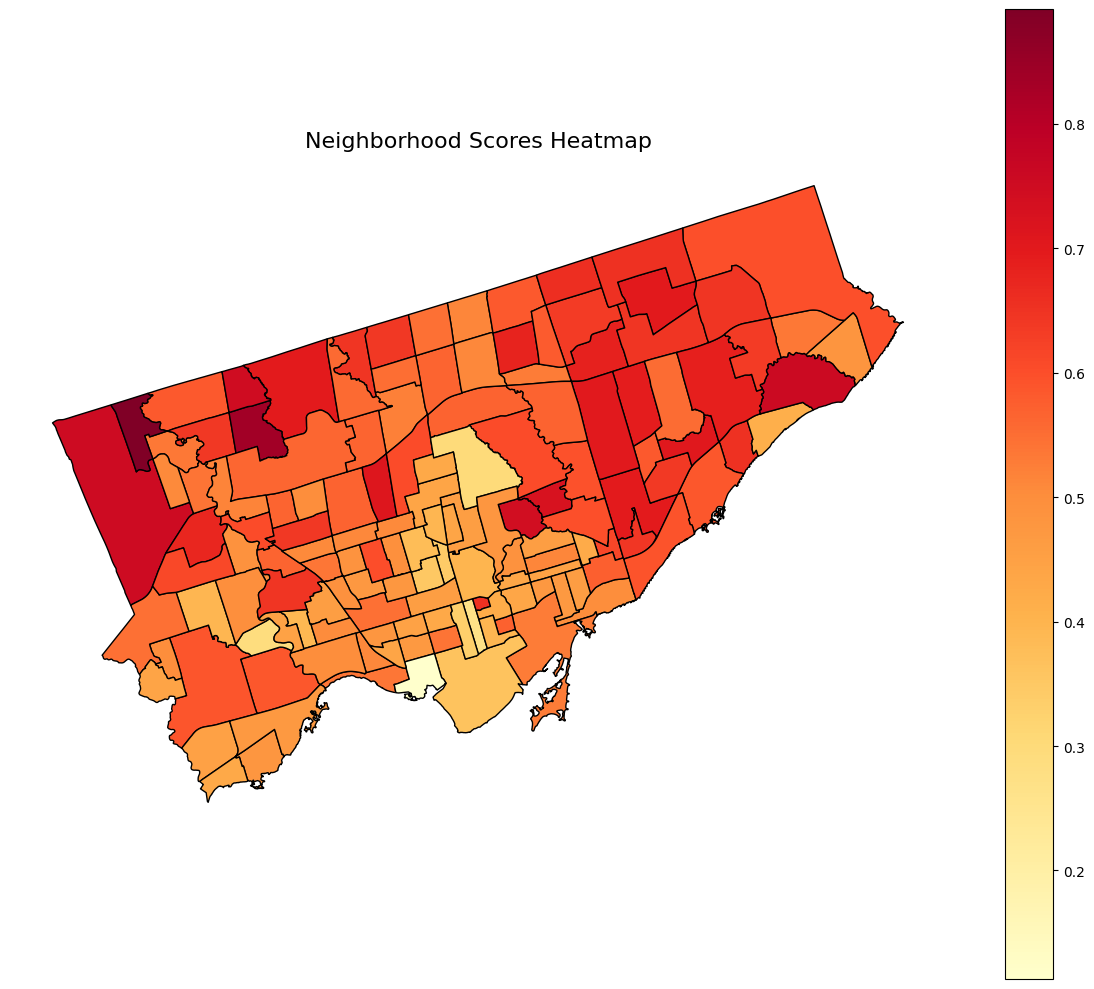

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the data
# Load the neighborhood scores Excel file
data_file = "neighborhood_scores.xlsx"
data = pd.read_excel(data_file)

# Load the shapefile
shapefile_path = "/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/neighborhood_shapefile/NEIGHBORHOODS_WGS84_2.shp"
neighborhoods = gpd.read_file(shapefile_path)
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Ensure the Neighborhood IDs align
# Rename columns for consistency
data.rename(columns={"Neighborhood ID": "AREA_S_CD"}, inplace=True)

# Standardize IDs in the Excel file
data["AREA_S_CD"] = data["AREA_S_CD"].astype(str).str.zfill(3)

# Standardize IDs in the shapefile
neighborhoods["AREA_S_CD"] = neighborhoods["AREA_S_CD"].astype(str).str.zfill(3)


# Merge the data
# Merge the shapefile with the Excel data on "AREA_S_CD"
merged = neighborhoods.merge(data[["AREA_S_CD", "Score"]], on="AREA_S_CD", how="left")

#  Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the merged GeoDataFrame
merged.plot(
    column="Score",  # The column to base the heatmap on
    cmap="YlOrRd",   # Color map
    legend=True,     # Show a legend
    edgecolor="black",  # Add boundaries for neighborhoods
    ax=ax
)

# Customize plot appearance
ax.set_title("Neighborhood Scores Heatmap", fontsize=16)
ax.axis("off")  # Remove axis for better appearance

# Show the plot
plt.tight_layout()
plt.show()


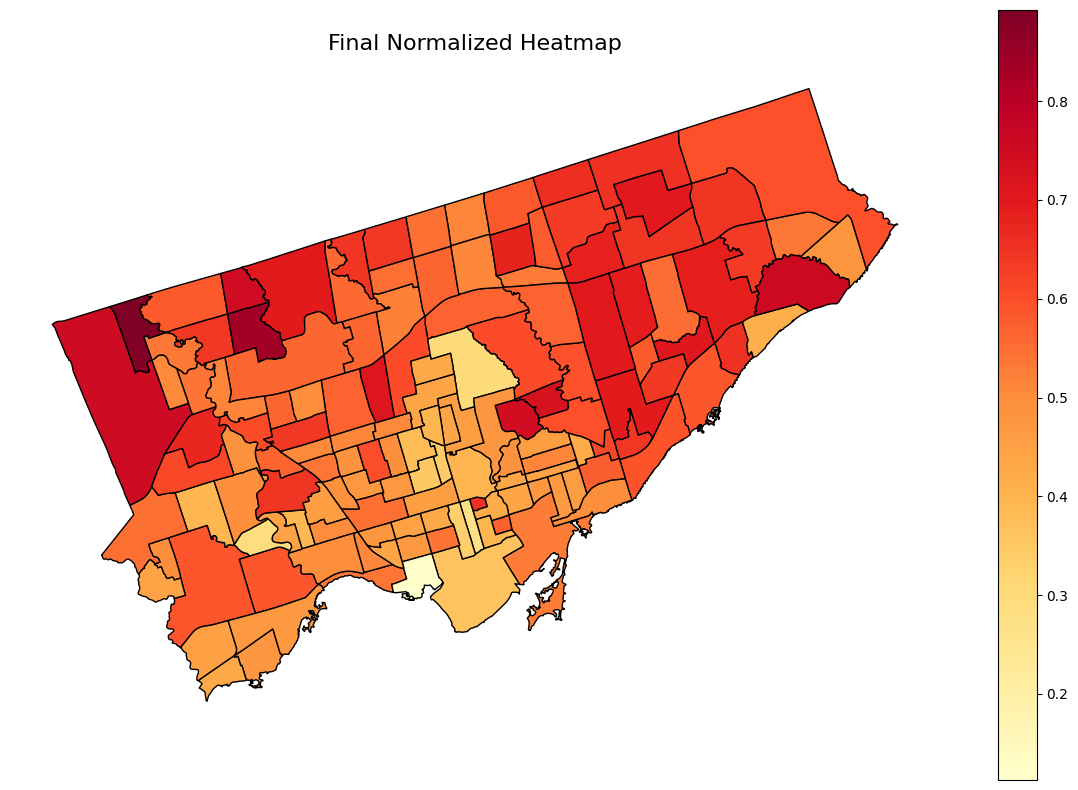

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
from shapely.geometry import Point

# Load the geospatial data and scores data
geo_df = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/neighborhood_shapefile/NEIGHBORHOODS_WGS84_2.shp")
scores_df = pd.read_csv("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/neighborhood_scores.xlsx - Sheet1.csv")

# Normalize AREA_S_CD for consistency
geo_df["AREA_S_CD"] = geo_df["AREA_S_CD"].astype(str).str.zfill(3)
scores_df.rename(columns={"Neighborhood ID": "AREA_S_CD"}, inplace=True)
scores_df["AREA_S_CD"] = scores_df["AREA_S_CD"].astype(str).str.zfill(3)

# Merge data
merged_df = geo_df.merge(scores_df, on="AREA_S_CD")

# Project to a UTM CRS for accurate calculations
merged_df = merged_df.to_crs(epsg=32617)  # Example for Toronto's UTM Zone
merged_df["x"] = merged_df.geometry.centroid.x
merged_df["y"] = merged_df.geometry.centroid.y

# Filter high-need neighborhoods
high_score_threshold = merged_df["Score"].quantile(0.75)
high_need_df = merged_df.loc[merged_df["Score"] >= high_score_threshold].copy()

# Weight the score feature more heavily
high_need_df["normalized_score"] = (high_need_df["Score"] - high_need_df["Score"].min()) / (
    high_need_df["Score"].max() - high_need_df["Score"].min()
)

# Scale up the score for prioritization (adjust weight as needed)
score_weight = 1000  # Adjust this to balance geographic vs. score importance
coords_with_weighted_score = high_need_df[["x", "y"]].values
coords_with_weighted_score = np.hstack(
    [
        coords_with_weighted_score,
        (high_need_df["normalized_score"] * score_weight).values.reshape(-1, 1),
    ]
)

# Perform DBSCAN clustering with weighted data
db = DBSCAN(eps=2000, min_samples=2).fit(coords_with_weighted_score)
high_need_df["cluster"] = db.labels_

# Summarize clusters
cluster_counts = high_need_df.groupby("cluster").size().reset_index(name="count")
cluster_scores = high_need_df.groupby("cluster")["Score"].mean().reset_index(name="avg_score")
cluster_summary = pd.merge(cluster_counts, cluster_scores, on="cluster")
cluster_summary = cluster_summary[cluster_summary["cluster"] != -1]
cluster_summary["priority"] = cluster_summary["avg_score"]
cluster_summary = cluster_summary.sort_values(by="priority", ascending=False)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Heatmap of all scores
merged_df.to_crs(epsg=4326).plot(
    ax=ax,
    column="Score",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    label="All Neighborhoods",
)


# Title and axis adjustments
ax.set_title("Final Normalized Heatmap", fontsize=16)
ax.set_axis_off()

# Save and display the plot
plt.savefig("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/prioritized_locations_colored.png")
plt.show()



In [ ]:
from sklearn.metrics import silhouette_score

# Perform DBSCAN clustering with weighted data
db = DBSCAN(eps=2000, min_samples=2).fit(coords_with_weighted_score)
high_need_df["cluster"] = db.labels_

# Calculate the silhouette score
# Exclude noise points (label -1)
filtered_df = high_need_df[high_need_df["cluster"] != -1]

# If there are enough points to compute the silhouette score
if len(filtered_df) > 1:
    # Calculate the silhouette score using the coordinates (x, y) as features
    silhouette_avg = silhouette_score(filtered_df[["x", "y"]], filtered_df["cluster"])
    print(f"Silhouette Score: {silhouette_avg:.3f}")
else:
    print("Not enough points to calculate silhouette score.")


Silhouette Score: 0.602


In [ ]:
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic

# Load the geospatial data
geo_df = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/neighborhood_shapefile/NEIGHBORHOODS_WGS84_2.shp")

# Ensure the CRS is in EPSG:4326 (latitude/longitude) for accurate distance calculation
geo_df = geo_df.to_crs(epsg=4326)

# Check the unique neighborhood names to ensure correct selection
print(geo_df['AREA_NAME'].unique())

# Filter for the two neighborhoods of interest (ensure exact name match)
neighborhoods_of_interest = ["Thorncliffe Park (55)", "Flemingdon Park (44)"]

# Check if these neighborhoods exist in the dataset
selected_neighborhoods = geo_df[geo_df["AREA_NAME"].isin(neighborhoods_of_interest)]

# Check if both neighborhoods are found in the dataset
if len(selected_neighborhoods) == 2:
    # Extract the centroids (geometrical centers) of the selected neighborhoods
    centroid_1 = selected_neighborhoods.iloc[0].geometry.centroid
    centroid_2 = selected_neighborhoods.iloc[1].geometry.centroid

    # Calculate the geodesic distance between the two centroids
    distance = geodesic(
        (centroid_1.y, centroid_1.x),  # Latitude, Longitude of the first neighborhood centroid
        (centroid_2.y, centroid_2.x),  # Latitude, Longitude of the second neighborhood centroid
    ).meters

    # Output the calculated distance
    print(f"The geographical distance between {neighborhoods_of_interest[0]} and {neighborhoods_of_interest[1]} is: {distance:.2f} meters")
else:
    print("One or both neighborhoods are not found in the dataset.")


['Yonge-St.Clair (97)' 'York University Heights (27)'
 'Lansing-Westgate (38)' 'Yorkdale-Glen Park (31)'
 'Stonegate-Queensway (16)' "Tam O'Shanter-Sullivan (118)"
 'The Beaches (63)' 'Thistletown-Beaumond Heights (3)'
 'Thorncliffe Park (55)' 'Danforth East York (59)'
 'Humewood-Cedarvale (106)' 'Islington-City Centre West (14)'
 'Danforth (66)' 'Rustic (28)' 'Scarborough Village (139)'
 'South Parkdale (85)' 'South Riverdale (70)' 'St.Andrew-Windfields (40)'
 'Taylor-Massey (61)' 'Humber Summit (21)' 'Humbermede (22)'
 'Centennial Scarborough (133)' 'Church-Yonge Corridor (75)'
 'Clairlea-Birchmount (120)' 'Cliffcrest (123)' 'Flemingdon Park (44)'
 'Corso Italia-Davenport (92)' 'Ionview (125)' 'Junction Area (90)'
 'Broadview North (57)' 'Princess-Rosethorn (10)' 'North Riverdale (68)'
 'Etobicoke West Mall (13)' 'Forest Hill North (102)'
 'Glenfield-Jane Heights (25)' 'Greenwood-Coxwell (65)' 'Guildwood (140)'
 'Trinity-Bellwoods (81)' 'Victoria Village (43)'
 'Waterfront Communitie

In [ ]:
city_boundary = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/toronto-boundary/citygcs_regional_mun_wgs84.shp")
ttc_routes = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/ttc-shapefile/TTC_SUBWAY_LINES_WGS84.shp")
bus_routes = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/Toronto_TTC_Routes/Toronto_TTC_Routes.shp")
schools = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/School locations-all types data - 4326/School locations-all types data - 4326.shp")
mental_health_services = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/mental-health-locations/YOUTH_MENTALHEALTH_WGS84.shp")
neighborhoods_boundary = gpd.read_file("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/neighborhood_shapefile/NEIGHBORHOODS_WGS84_2.shp")

Cluster Summary (Sorted by Total Score):
   cluster  count  avg_score  priority
2        1      2   0.734111  0.734111
6        5      2   0.698034  0.698034
7        6      3   0.665319  0.665319
1        0      2   0.659412  0.659412
3        2      3   0.650951  0.650951
4        3      2   0.643889  0.643889
5        4      2   0.642985  0.642985
Top Cluster Based on Total Score: Cluster 1


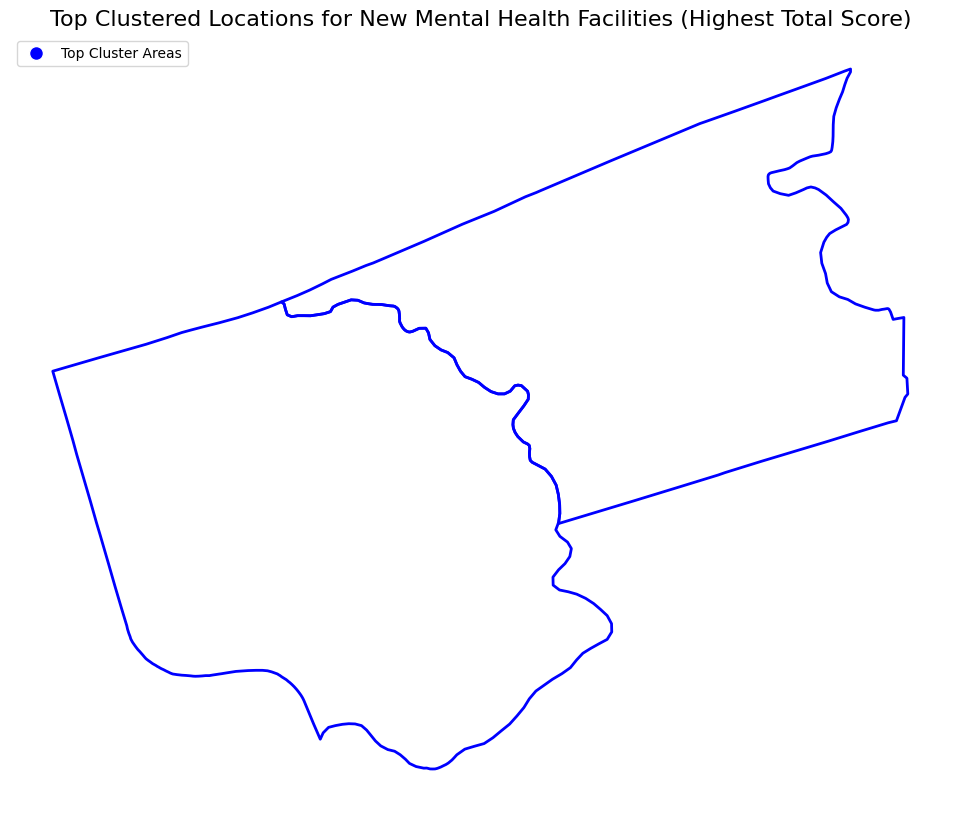

Selected Neighborhoods for New Facilities:
                AREA_NAME     Score  cluster
8   Thorncliffe Park (55)  0.741813        1
25   Flemingdon Park (44)  0.726409        1


In [ ]:
# Summarize clusters
cluster_counts = high_need_df.groupby("cluster").size().reset_index(name="count")
cluster_scores = high_need_df.groupby("cluster")["Score"].mean().reset_index(name="avg_score")
cluster_summary = pd.merge(cluster_counts, cluster_scores, on="cluster")
cluster_summary = cluster_summary[cluster_summary["cluster"] != -1]
cluster_summary["priority"] = cluster_summary["avg_score"]
cluster_summary = cluster_summary.sort_values(by="priority", ascending=False)

# Print out the cluster summary to check the total scores
print("Cluster Summary (Sorted by Total Score):")
print(cluster_summary)

# Select the top cluster based on total score
top_cluster = cluster_summary.head(1)["cluster"].values[0]  # Get the cluster with the highest total score
print(f"Top Cluster Based on Total Score: Cluster {top_cluster}")

# Select neighborhoods from the top cluster
selected_neighborhoods = high_need_df[high_need_df["cluster"] == top_cluster].copy()

# Plotting boundaries of the top cluster only
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the boundaries of the top cluster neighborhoods
selected_neighborhoods.to_crs(epsg=4326).plot(
    ax=ax,
    color="none",
    edgecolor="blue",
    linewidth=2,
    label="Top Cluster Areas",
)

# Custom legend
handles = [
    plt.Line2D([0], [0], marker="o", color="w", label="Top Cluster Areas", markersize=10, markerfacecolor="blue"),
]
ax.legend(handles=handles, loc="upper left")

# Title and axis adjustments
ax.set_title("Top Clustered Locations for New Mental Health Facilities (Highest Total Score)", fontsize=16)
ax.set_axis_off()

# Save and display the plot
plt.savefig("/content/drive/MyDrive/Mental Health Location BDC 2024 Datafiles/top_cluster_boundaries.png")
plt.show()

# Output selected neighborhoods
output = selected_neighborhoods[["AREA_NAME", "Score", "cluster"]]
print("Selected Neighborhoods for New Facilities:")
print(output)


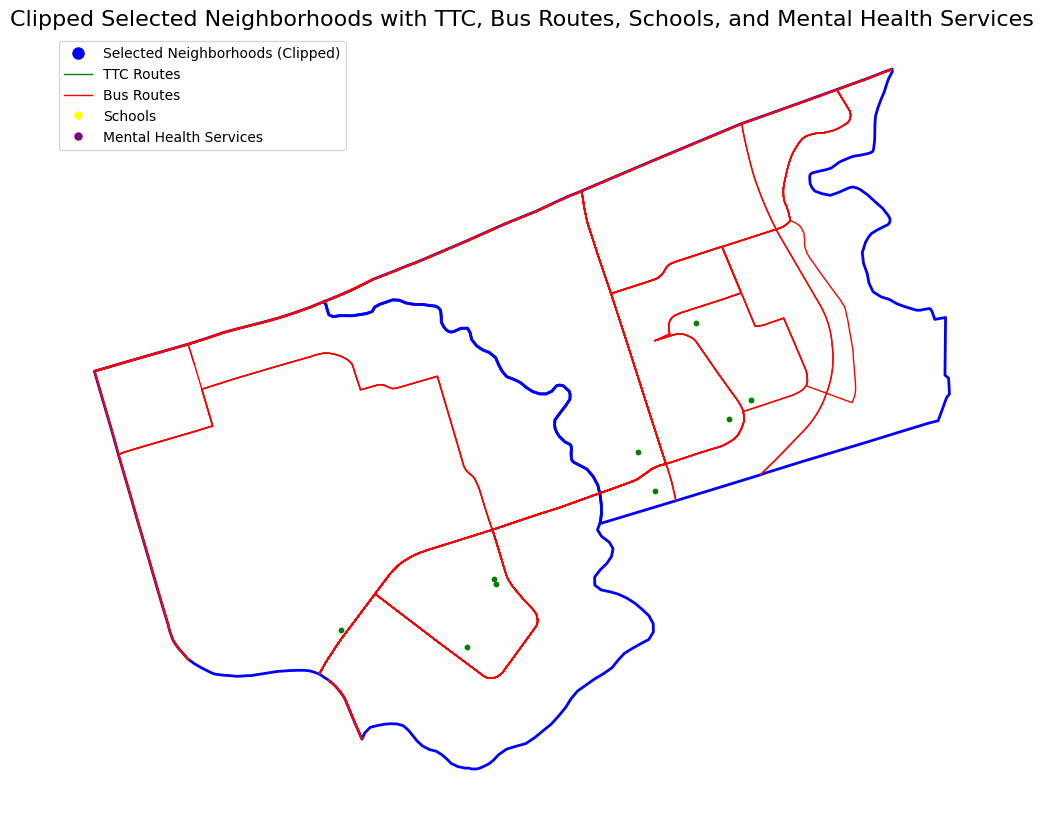

In [ ]:
# Ensure all layers are in the same CRS (EPSG:4326)
selected_neighborhoods = selected_neighborhoods.to_crs(epsg=4326)  # Ensure neighborhoods CRS
ttc_routes = ttc_routes.to_crs(epsg=4326)
bus_routes = bus_routes.to_crs(epsg=4326)
schools = schools.to_crs(epsg=4326)
mental_health_services = mental_health_services.to_crs(epsg=4326)

# Check and clean geometries (optional but can help with invalid geometry issues)
selected_neighborhoods = selected_neighborhoods[selected_neighborhoods.is_valid]
ttc_routes = ttc_routes[ttc_routes.is_valid]
bus_routes = bus_routes[bus_routes.is_valid]
schools = schools[schools.is_valid]
mental_health_services = mental_health_services[mental_health_services.is_valid]

# Clip all relevant data layers to the selected neighborhoods
ttc_routes_clipped = gpd.clip(ttc_routes, selected_neighborhoods)
bus_routes_clipped = gpd.clip(bus_routes, selected_neighborhoods)
schools_clipped = gpd.clip(schools, selected_neighborhoods)
mental_health_services_clipped = gpd.clip(mental_health_services, selected_neighborhoods)

# Plotting the clipped boundaries
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the clipped selected neighborhoods
selected_neighborhoods.plot(
    ax=ax,
    color="none",
    edgecolor="blue",
    linewidth=2,
    label="Selected Neighborhoods (Clipped)"
)

if not ttc_routes_clipped.empty:
    ttc_routes_clipped.plot(ax=ax, color="green", linewidth=1, label="TTC Routes")
if not bus_routes_clipped.empty:
    bus_routes_clipped.plot(ax=ax, color="red", linewidth=1, label="Bus Routes")
if not schools_clipped.empty:
    schools_clipped.plot(ax=ax, color="green", markersize=10, label="Schools")
if not mental_health_services_clipped.empty:
    mental_health_services_clipped.plot(ax=ax, color="purple", markersize=5, label="Mental Health Services")


# Custom legend
handles = [
    plt.Line2D([0], [0], marker="o", color="w", label="Selected Neighborhoods (Clipped)", markersize=10, markerfacecolor="blue"),
    plt.Line2D([0], [0], color="green", linewidth=1, label="TTC Routes"),
    plt.Line2D([0], [0], color="red", linewidth=1, label="Bus Routes"),
    plt.Line2D([0], [0], color="yellow", linewidth=0, marker="o", markersize=5, label="Schools"),
    plt.Line2D([0], [0], color="purple", linewidth=0, marker="o", markersize=5, label="Mental Health Services"),
]
ax.legend(handles=handles, loc="upper left")

# Title and axis adjustments
ax.set_title("Clipped Selected Neighborhoods with TTC, Bus Routes, Schools, and Mental Health Services", fontsize=16)
ax.set_axis_off()

# Save and display the plot
plt.show()


Grid Points Coordinates:
(-79.364802153, 43.69826169)
(-79.364802153, 43.70125390044445)
(-79.364802153, 43.70424611088889)
(-79.364802153, 43.707238321333335)
(-79.364802153, 43.71023053177778)
(-79.364802153, 43.71322274222222)
(-79.364802153, 43.71621495266667)
(-79.364802153, 43.719207163111115)
(-79.364802153, 43.722199373555554)
(-79.364802153, 43.725191584)
(-79.35974564433333, 43.69826169)
(-79.35974564433333, 43.70125390044445)
(-79.35974564433333, 43.70424611088889)
(-79.35974564433333, 43.707238321333335)
(-79.35974564433333, 43.71023053177778)
(-79.35974564433333, 43.71322274222222)
(-79.35974564433333, 43.71621495266667)
(-79.35974564433333, 43.719207163111115)
(-79.35974564433333, 43.722199373555554)
(-79.35974564433333, 43.725191584)
(-79.35468913566666, 43.69826169)
(-79.35468913566666, 43.70125390044445)
(-79.35468913566666, 43.70424611088889)
(-79.35468913566666, 43.707238321333335)
(-79.35468913566666, 43.71023053177778)
(-79.35468913566666, 43.71322274222222)
(-79.3

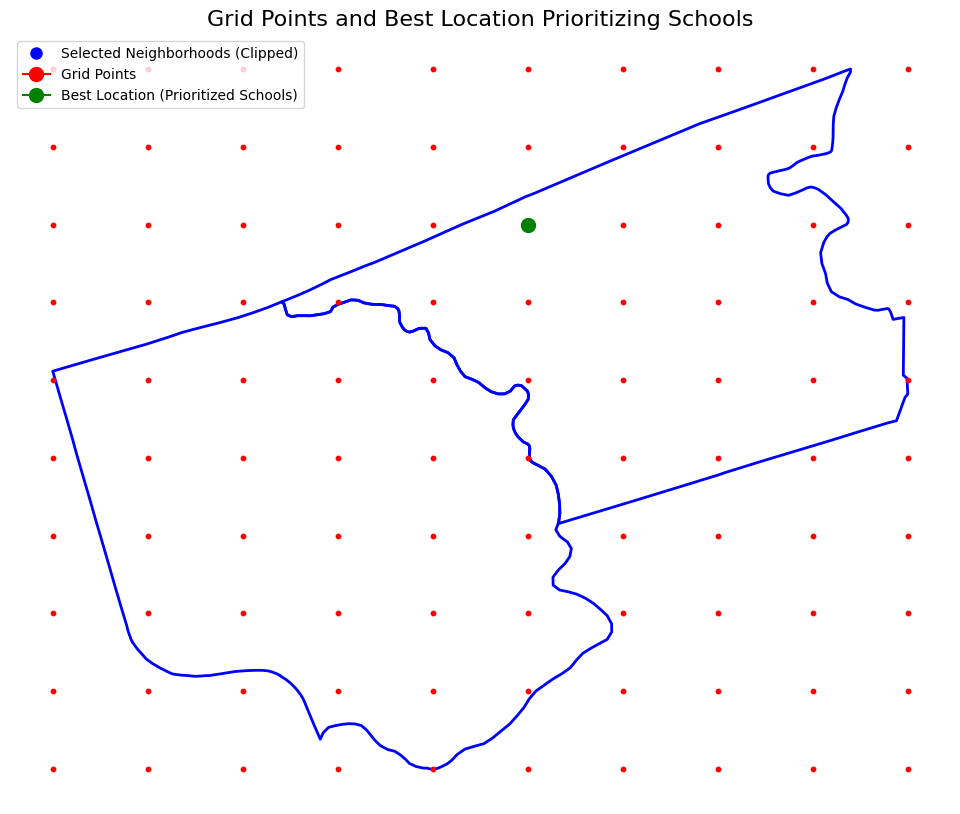

Best Location Coordinates (Prioritized Schools): -79.33951960966667, 43.719207163111115


In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Generate a grid of points within the selected neighborhoods
# Define grid resolution (higher = finer resolution)
resolution = 10  # Adjust as needed
minx, miny, maxx, maxy = selected_neighborhoods.total_bounds
x_coords = np.linspace(minx, maxx, resolution)
y_coords = np.linspace(miny, maxy, resolution)

# Create a list of grid points (each as a Point geometry)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=selected_neighborhoods.crs)

# Print the coordinates of the grid points
print("Grid Points Coordinates:")
for point in grid_gdf.geometry:
    print(f"({point.x}, {point.y})")

# Calculate weighted distances for each grid point
# Define weights (e.g., prioritize schools more)
school_weight = 2  # Give schools more priority (higher value = higher priority)
bus_route_weight = 1  # Standard priority for bus routes

min_distance_sum = float("inf")
best_point = None

# Convert coordinates to radians for distance calculation
def to_radians(geom):
    return np.radians([geom.x, geom.y])

# Get the coordinates of schools (Point geometries)
schools_coords = np.array([to_radians(sch) for sch in schools_clipped.geometry])

# Get the distances to bus routes (handle both Point and LineString geometries)
bus_route_distances = []
for bus in bus_routes_clipped.geometry:
    if isinstance(bus, Point):
        bus_route_distances.append(np.array([to_radians(bus)]))
    else:  # Handle LineString
        bus_route_distances.append([to_radians(Point(bus.interpolate(0.5)))])  # Use midpoint for simplicity

bus_route_distances = np.concatenate(bus_route_distances)

# Iterate over the grid points to find the best location
for point in grid_gdf.geometry:
    point_coords = to_radians(point)

    # Calculate distance to all schools and bus routes (in radians)
    school_distances = np.linalg.norm(schools_coords - point_coords, axis=1)
    bus_route_distances_to_point = np.array([point.distance(bus) for bus in bus_routes_clipped.geometry])

    # Weight the distances for schools more heavily
    weighted_school_distances = school_weight * np.sum(school_distances)
    weighted_bus_route_distances = bus_route_weight * np.sum(bus_route_distances_to_point)

    # Total weighted distance
    total_distance = weighted_school_distances + weighted_bus_route_distances

    # Update best point if this grid point is better
    if total_distance < min_distance_sum:
        min_distance_sum = total_distance
        best_point = point

# Plot the best point on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the clipped selected neighborhoods
selected_neighborhoods.plot(
    ax=ax,
    color="none",
    edgecolor="blue",
    linewidth=2,
    label="Selected Neighborhoods (Clipped)"
)

# Plot the grid points (red dots)
grid_gdf.plot(ax=ax, color="red", markersize=10, label="Grid Points")

# Plot the best point (as a red marker)
ax.scatter(best_point.x, best_point.y, color="green", s=100, label="Best Location (Prioritized Schools)")

# Custom legend
handles = [
    plt.Line2D([0], [0], marker="o", color="w", label="Selected Neighborhoods (Clipped)", markersize=10, markerfacecolor="blue"),
    plt.Line2D([0], [0], marker="o", color="r", markersize=10, label="Grid Points"),
    plt.Line2D([0], [0], marker="o", color="g", markersize=10, label="Best Location (Prioritized Schools)")
]
ax.legend(handles=handles, loc="upper left")

# Title and axis adjustments
ax.set_title("Grid Points and Best Location Prioritizing Schools", fontsize=16)
ax.set_axis_off()

# Save and display the plot
plt.show()

# Output best point coordinates
print(f"Best Location Coordinates (Prioritized Schools): {best_point.x}, {best_point.y}")


<ipython-input-20-2c033b93a080>:80: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


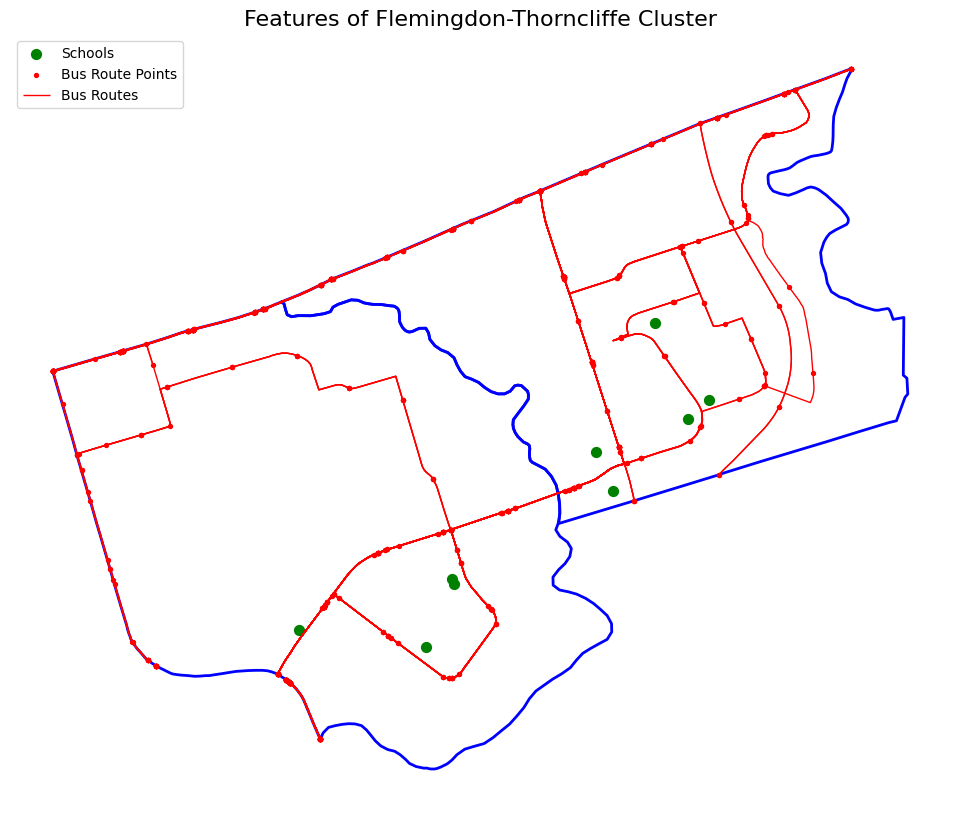

223
Best Location Coordinates: (-79.34754027858621, 43.703833392206896)


In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Transform bus routes into points with equal gaps
def line_to_points(line, gap=0.0034):
    """Convert a LineString into points with an equal gap."""
    if line.length == 0:  # Handle zero-length LineString
        return [Point(line.coords[0])]

    num_points = max(1, int(line.length / gap))  # Ensure at least one point is generated
    return [Point(line.interpolate(i / num_points, normalized=True)) for i in range(num_points + 1)]

# Collect all points from bus routes
bus_points = []
for route in bus_routes_clipped.geometry:
    if route.geom_type == "LineString":
        bus_points.extend(line_to_points(route))
    elif route.geom_type == "MultiLineString":
        for sub_route in route.geoms:  # Use `.geoms` to access components of MultiLineString
            bus_points.extend(line_to_points(sub_route))
    elif route.geom_type == "Point":  # If bus routes contain Point geometries
        bus_points.append(route)

# Convert bus points into a GeoDataFrame
bus_points_gdf = gpd.GeoDataFrame(geometry=bus_points, crs=bus_routes_clipped.crs)

# Parameters
distance_threshold = 0.006  # Threshold in map units (~1 km for lat/lon)
density_threshold = 1  # Minimum total points (schools + buses) for a valid grid point
highlight_radius = 0.006
# Generate a grid of points
resolution = 30  # Adjust grid resolution
minx, miny, maxx, maxy = selected_neighborhoods.total_bounds
x_coords = np.linspace(minx, maxx, resolution)
y_coords = np.linspace(miny, maxy, resolution)

grid_points = [Point(x, y) for x in x_coords for y in y_coords]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=selected_neighborhoods.crs)

# Count points within the radius
best_count = 0  # Higher counts are better
best_point = None

for grid_point in grid_gdf.geometry:
    # Count nearby schools and bus route points within the threshold
    school_count = sum(1 for school in schools_clipped.geometry if grid_point.distance(school) <= distance_threshold)
    bus_count = sum(1 for bus_point in bus_points if grid_point.distance(bus_point) <= distance_threshold)

    total_count = school_count + bus_count

    # Skip grid points with insufficient density
    if total_count < density_threshold:
        continue

    # Update the best point
    if total_count > best_count:
        best_count = total_count
        best_point = grid_point

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot selected neighborhoods
selected_neighborhoods.plot(
    ax=ax, color="none", edgecolor="blue", linewidth=2, label="Selected Neighborhoods"
)
# Plot schools and bus route points
schools_clipped.plot(ax=ax, color="green", markersize=50, label="Schools")
bus_points_gdf = gpd.GeoDataFrame(geometry=bus_points, crs=selected_neighborhoods.crs)
bus_points_gdf.plot(ax=ax, color="red", markersize=8, label="Bus Route Points")
bus_routes_clipped.plot(ax=ax, color="red", linewidth=1, label="Bus Routes")

# Plot grid points



# Add legend and title
ax.legend()
ax.set_title("Features of Flemingdon-Thorncliffe Cluster", fontsize=16)
ax.set_axis_off()

# Display the plot
plt.show()
points_in_radius = sum(1 for point in bus_points + list(schools_clipped.geometry) if highlight_area.contains(point))
print(points_in_radius)
# Output best point coordinates
if best_point:
    print(f"Best Location Coordinates: ({best_point.x}, {best_point.y})")
else:
    print("No suitable location found based on the density threshold.")
